In [1]:
import collections
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter

In [2]:
import PIPPET
import utils

In [23]:
#%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('default')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.autolayout'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
sns.set_context('paper', font_scale=0.9)

# Fitch & Rosenfeld (2007) rhythms

In [3]:
# [[rhythm], syncopation index, rhythm number]
from fitchrosenfeld_stimuli import FR2007_RHYTHMS

In [4]:
# "46 pulses", so 11 reps -> 46 * 60/110 = 25s, 46 * 60/75 = 36.8s
NOME_MEASURES = 2
STIM_REPS = 3

In [5]:
def to_times(bits):
    e_ts = ((np.ones(len(bits)) * 0.25).cumsum() - 0.25)[np.array(bits) > 0]
    return e_ts

fr_stims = []
for bits, _, _ in FR2007_RHYTHMS:
    bits_stim = ([1, 0, 0, 0] * 4 * NOME_MEASURES) + bits * STIM_REPS
    fr_stims.append(2*np.pi * to_times(bits_stim))

In [6]:
syncopation_scores = np.array([r[1] for r in FR2007_RHYTHMS])

# Simulations

In [7]:
p = PIPPET.PIPPETParams()
p.dt = 0.005
p.overtime = np.pi/2
lambda_0 = 0.001
p.sigma_phi = 0.2
p.mu_0 = 0
p.V_0 = 0.1
p.eta_mu = 0.00
p.eta_e = 0.0
p.eta_V = 0.00
e_means   = np.array([0.0])
e_vars    = np.array([0.01])
e_lambdas = np.array([0.01])

In [8]:
models = []
for stim in fr_stims:
    p_ = copy.deepcopy(p)
    p_.add(stim, e_means, e_vars, e_lambdas, lambda_0, '')
    m = PIPPET.cPIPPET(p_)
    models.append(m)

In [9]:
for i, m in enumerate(models):
    m.run()

KeyboardInterrupt: 

### Resetting statistics

In [31]:
all_ts = []
sync_counts = collections.Counter()
reset_perc = collections.defaultdict(float)
for sync, m in zip(syncopation_scores, models):
    # Find 0-crossings on phase
    inds = np.where((np.roll(m.mu_s, 1) < 0) & (m.mu_s > 0))[0]
    ts = m.ts[inds]
    all_ts.append(ts)
    # Check whether 0-crossings are closer to beats, or off-beats
    beats = np.arange(2*np.pi, m.tmax, 2*np.pi)
    offbeats = np.arange(np.pi, m.tmax, 2*np.pi)
    agg = 0
    for t in ts:
        agg += int(np.min(np.abs(beats - t)) > np.min(np.abs(offbeats - t)))
    reset_perc[sync] += agg/len(ts)
    sync_counts[sync] += 1
for sync, count in sync_counts.items():
    reset_perc[sync] /= count

ZeroDivisionError: division by zero

In [32]:
syncs, perc = zip(*reset_perc.items())
syncs, perc = list(syncs), list(perc)

In [33]:
lin = linregress(syncs, perc)
lin.rvalue, lin.pvalue

RuntimeWarning: invalid value encountered in scalar divide

### Resets & Phase Alignment

In [34]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
sns.regplot(x=syncs, y=np.array(perc)*100, order=1, color='dimgrey', ax=ax, robust=True)
ax.set_xlabel('Syncopation index (LHL)', fontsize=10, labelpad=5)
ax.set_ylabel('Tracking off-beat (% of stimulus)', fontsize=10, labelpad=5)
ax.set_ylim([-2, None])

fig.savefig('figures/fig_phasereset.pdf', bbox_inches='tight');

### Examples

In [10]:
# Phase
def _plot_phase(ax, model, from_i, to_i, col, offset=0):
    # Phase progress
    std = 2*np.sqrt(model.V_s[from_i:to_i])
    ax.plot(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset, c=col, linewidth=1.75)
    ax.fill_between(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset-std, model.mu_s[from_i:to_i]+offset+std, alpha=0.2, facecolor=col)
def _plot_phase_wraps(ax, model, col):
    # Find wrapping points
    xs = model.mu_s
    wrap_is = np.where((np.roll(np.sign(xs), 1) != np.sign(xs)) & (np.abs(xs) > 3.1))[0]
    prev_from = 0
    for i, wrap_i in enumerate(wrap_is):
        from_i = wrap_is[i-1] if i > 0 else 0
        to_i = wrap_is[i+1] if i < len(wrap_is)-1 else model.mu_s.size+1
        _plot_phase(ax, model, from_i, wrap_i, col)
        _plot_phase(ax, model, from_i, wrap_i, col, offset=-2*np.pi)
        _plot_phase(ax, model, wrap_i, to_i, col, offset=2*np.pi)
    _plot_phase(ax, model, wrap_is[-1], model.mu_s.size+1, col)
    
    
def _plot_example(ax, ax_temp, model, tmax=None):

    cs_b = ['deepskyblue', 'lightcoral']
    
    # Template
    utils.plot_template(model, ax_temp, ['black'], xlabelkwargs={'fontsize': 10, 'labelpad': 10}, ylabelkwargs={'fontsize': 10})

    # Stimulus/Auditory events
    #utils.plot_events(model, ax, ax_temp, cols=['lightgray'], stimulus=False, expected=True)
    # Events
    ax.vlines(model.ts[list(model.idx_event)], -np.pi, np.pi, color='dimgray', alpha=0.9, linestyle='--', linewidth=1, label='Stimulus events')

    # Phase progress
    _plot_phase_wraps(ax, model, 'black')
    ax.set_xlabel('Time', fontsize=10, labelpad=10)

    # Beats
    ax.scatter(np.arange(20)*2*np.pi, [0]*20, color=cs_b[0], alpha=1, marker='o', s=50, label='Stimulus beats')
    # Offbeats
    ax.scatter(np.arange(20)*2*np.pi + np.pi, [0]*20, color=cs_b[1], alpha=1, marker='o', s=50, label='Stimulus off-beats')

    # Tidying
    if tmax is None:
        tmax = model.tmax
    ax.set_xlim([model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]], tmax])
    #ax.set_xlim([0, model.tmax])
    ax.set_ylim([-np.pi, np.pi])
    #ax.axhline(-np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)
    #ax.axhline(np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_temp.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax_temp.tick_params(axis='both', which='major', labelsize=8)

    ax_temp.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax_temp.set_yticklabels([r'$-\,\pi$', r'$-\,\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=12)

    leg = ax.legend(edgecolor='k', loc='upper left')
    leg.get_frame().set_alpha(None)
    
    
def _plot_rose(ax, xs, col):

    # Force bins to partition entire circle
    bins = np.linspace(-np.pi, np.pi, num=16)

    # Wrap angles to [-pi, pi)
    xs = (xs+np.pi) % (2*np.pi) - np.pi
    # Bin data and record counts
    n, bins = np.histogram(xs, bins=bins)
    widths = np.diff(bins)
    # Area to assign each bin
    area = n / xs.size
    # Calculate corresponding bin radius
    radius = (area/np.pi) ** .5
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     color=col, edgecolor=col, fill=True, alpha=0.9, linewidth=1)

    ax.set_theta_offset(0)
    ax.set_yticks([])

    ax.grid(linewidth=1, linestyle='-.', color='lightgray', alpha=0.5)
    xL = ['0', r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',
               r'$\pm\pi$',r'$-\,\frac{3\pi}{4}$',r'$-\,\frac{\pi}{2}$',r'$-\,\frac{\pi}{4}$']
    ax.set_xticklabels(xL, fontsize=10)
    ax.set_xlabel('Phase alignment across stimulus', fontsize=10, labelpad=8)
    
    ax.set_rlim([0, .65])

IndexError: index -1 is out of bounds for axis 0 with size 0

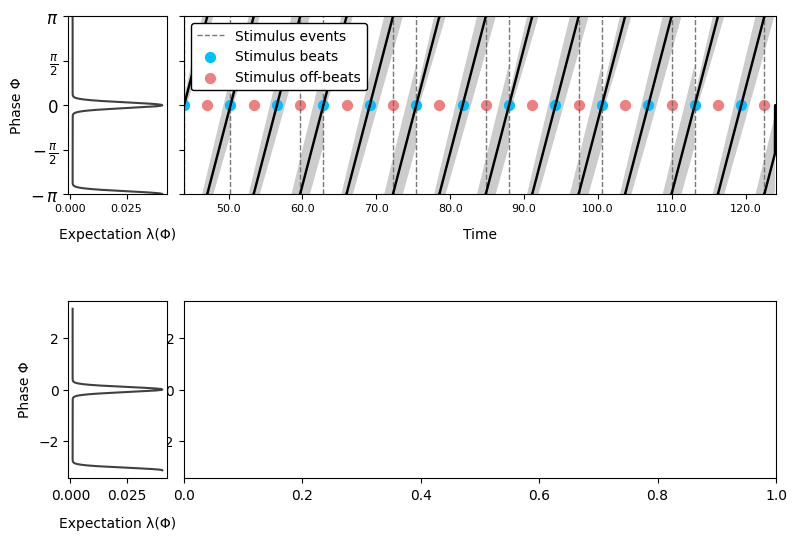

In [11]:
fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(2, 2, height_ratios=(1, 1), width_ratios=(4.5, 1), wspace=0.15, hspace=0.6)

# Phase

gs_1 = gs[0].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)
gs_2 = gs[2].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)

ax_1 = fig.add_subplot(gs_1[1])
ax_temp_1 = fig.add_subplot(gs_1[0], sharey=ax_1)
_plot_example(ax_1, ax_temp_1, models[0])


ax_2 = fig.add_subplot(gs_2[1])
ax_temp_2 = fig.add_subplot(gs_2[0], sharey=ax_2)
_plot_example(ax_2, ax_temp_2, models[10])

ax_temp_1.annotate('A', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)
ax_temp_2.annotate('B', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)

# Rose

ax_1p = fig.add_subplot(gs[1], projection='polar')
model = models[0]
start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
ts = all_ts[0][np.where(all_ts[0] > start_from)[0]]
_plot_rose(ax_1p, ts, 'slategrey')

ax_2p = fig.add_subplot(gs[3], projection='polar')
model = models[10]
start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
ts = all_ts[10][np.where(all_ts[10] > start_from)[0]]
_plot_rose(ax_2p, ts, 'slategrey')


#fig.savefig('figures/fig_phasereset_examples.jpeg', bbox_inches='tight');
pass

Zoomed in, somewhat:

IndexError: index -1 is out of bounds for axis 0 with size 0

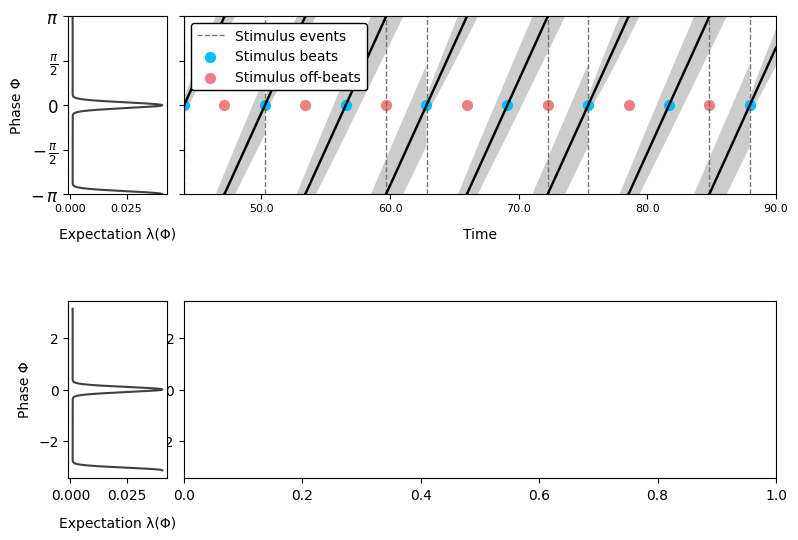

In [12]:
fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(2, 2, height_ratios=(1, 1), width_ratios=(4.5, 1), wspace=0.15, hspace=0.6)

# Phase

gs_1 = gs[0].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)
gs_2 = gs[2].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)

ax_1 = fig.add_subplot(gs_1[1])
ax_temp_1 = fig.add_subplot(gs_1[0], sharey=ax_1)
_plot_example(ax_1, ax_temp_1, models[0], tmax=90)


ax_2 = fig.add_subplot(gs_2[1])
ax_temp_2 = fig.add_subplot(gs_2[0], sharey=ax_2)
_plot_example(ax_2, ax_temp_2, models[10], tmax=90)

ax_temp_1.annotate('A', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)
ax_temp_2.annotate('B', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)

# Rose

ax_1p = fig.add_subplot(gs[1], projection='polar')
model = models[0]
start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
ts = all_ts[0][np.where(all_ts[0] > start_from)[0]]
_plot_rose(ax_1p, ts, 'slategrey')

ax_2p = fig.add_subplot(gs[3], projection='polar')
model = models[10]
start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
ts = all_ts[10][np.where(all_ts[10] > start_from)[0]]
_plot_rose(ax_2p, ts, 'slategrey')


fig.tight_layout()

plt.subplots_adjust(top=1.1)

fig.savefig('figures/fig_phasereset_examples.pdf', bbox_inches='tight');
pass

In [13]:
p2 = PIPPET.PIPPETParams()
p2.dt = 0.005
p2.overtime = 2*np.pi
p2.lambda_0 = 0.001
p2.sigma_phi = 0.4
p2.mu_0 = 0
p2.V_0 = 0.1
p2.eta_mu = 0.00
p2.eta_e = 0.0
p2.eta_V = 0.00
e_means2   = np.array([0.0, np.pi])
e_vars2    = np.array([0.01,.1])
e_lambdas2 = np.array([0.01, .003])

[  0.           6.28318531  12.56637061  18.84955592  25.13274123
  31.41592654  37.69911184  43.98229715  50.26548246  59.69026042
  65.97344573  72.25663103  75.39822369  84.82300165  91.10618695
  97.38937226 100.53096491 109.95574288 116.23892818 122.52211349]


UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

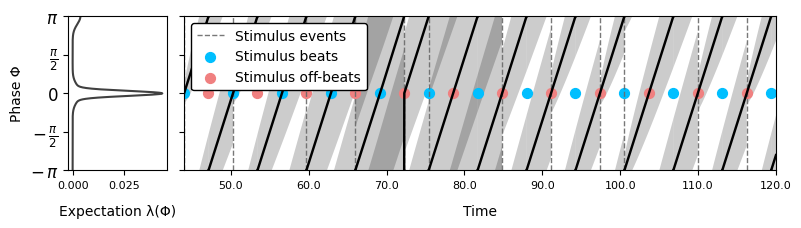

In [14]:
unit = np.array([0, 3*np.pi, 5*np.pi, 7*np.pi])
stim=np.concatenate((np.arange(0, 8)*np.pi*2, unit+16*np.pi, unit+16*np.pi+8*np.pi, unit+16*np.pi+16*np.pi))
print(stim)
p_ = copy.deepcopy(p2)
p_.add(stim, e_means2, e_vars2, e_lambdas2, 0, '')
m2 = PIPPET.cPIPPET(p_)
m2.run()
    
inds = np.where((np.roll(m2.mu_s, 1) < 0) & (m2.mu_s > 0))[0]
ts_2 = m2.ts[inds]
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, 2, width_ratios=(4.5, 1), wspace=0.15, hspace=0.6)
# Phase
gs_1 = gs[0].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)
ax_1 = fig.add_subplot(gs_1[1])
ax_temp_1 = fig.add_subplot(gs_1[0], sharey=ax_1)
_plot_example(ax_1, ax_temp_1, m2, tmax=120)
fig.tight_layout()
plt.show()

UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

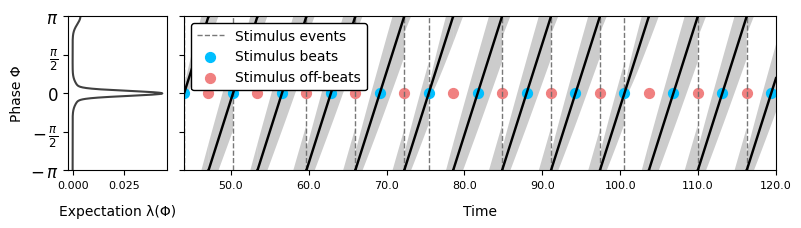

In [16]:
p_3 = copy.deepcopy(p_)
p_3.sigma_phi = .3
m3 = PIPPET.cPIPPET(p_3)
m3.run()
inds = np.where((np.roll(m3.mu_s, 1) < 0) & (m3.mu_s > 0))[0]
ts_3 = m3.ts[inds]
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, 2, width_ratios=(4.5, 1), wspace=0.15, hspace=0.6)
# Phase
gs_1 = gs[0].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)
ax_1 = fig.add_subplot(gs_1[1])
ax_temp_1 = fig.add_subplot(gs_1[0], sharey=ax_1)
_plot_example(ax_1, ax_temp_1, m3, tmax=120)
fig.tight_layout()
plt.show()

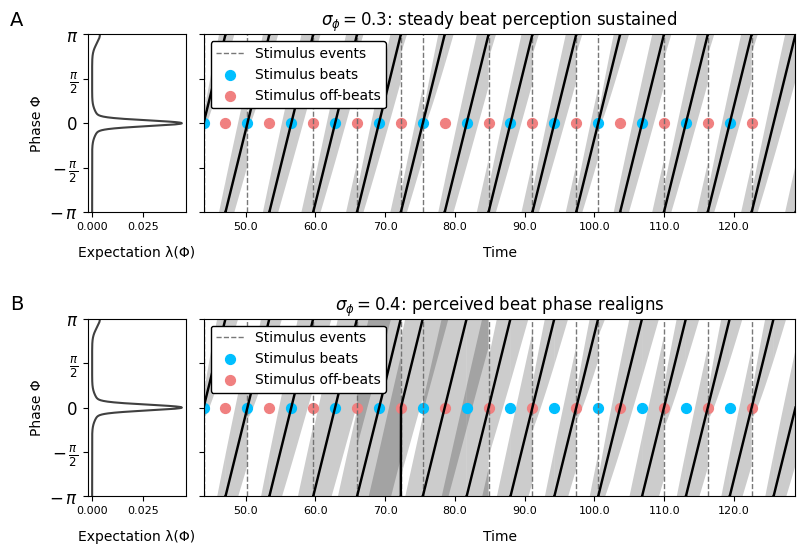

In [17]:
fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(2, 2, height_ratios=(1, 1), width_ratios=(4.5, 1), wspace=0.15, hspace=0.6)

# Phase

gs_1 = gs[0].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)
gs_2 = gs[2].subgridspec(1, 2, width_ratios=(1, 6), wspace=0.05)

ax_1 = fig.add_subplot(gs_1[1])
ax_temp_1 = fig.add_subplot(gs_1[0], sharey=ax_1)
_plot_example(ax_1, ax_temp_1, m3)
ax_1.set_title(r'$\sigma_\phi=0.3$: steady beat perception sustained')


ax_2 = fig.add_subplot(gs_2[1])
ax_temp_2 = fig.add_subplot(gs_2[0], sharey=ax_2)
_plot_example(ax_2, ax_temp_2, m2)
ax_2.set_title(r'$\sigma_\phi=0.4$: perceived beat phase realigns')

ax_temp_1.annotate('A', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)
ax_temp_2.annotate('B', xy=(-0.04, np.pi*1.1), fontsize=14, annotation_clip=False)

# Rose

#ax_1p = fig.add_subplot(gs[1], projection='polar')
#model = m3
#start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
#ts = ts_3[np.where(ts_3 > start_from)[0]]
#_plot_rose(ax_1p, ts, 'slategrey')

#ax_2p = fig.add_subplot(gs[3], projection='polar')
#model = m2
#start_from = model.ts[list(sorted(model.idx_event))[4*NOME_MEASURES - 1]]
#ts = ts_2[np.where(ts_2 > start_from)[0]]
#_plot_rose(ax_2p, ts, 'slategrey')


fig.savefig('figures/fig_phasereset_simple_example.png', bbox_inches='tight');
pass